## Setup

In [1]:
# RUN SETUP.SH BEFORE RUNNING THIS IPYNB
# REQUIREMENTS FOR SETUP.SH:
# python 3.11.8
# pip 23.3.1

import pandas as pd
import pickle
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression Classifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN, RandomOverSampler
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz
import spacy
import re
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif
import nltk
from readability import Readability
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances
import csv

In [2]:
SEED = 42 # seed random state for comparison, testing
PARTITION_SIZE = 500 # Adjust lower if potato PC and higher if gaming rig or want results closer to actual
enable_all_data = True # SET TO FALSE IF PREPROCESSING TAKES A LONG TIME (True = test on PARTITION_SIZE training and PARTITION_SIZE testing samples)
enable_preprocessed_from_savefile = True
enable_features_from_savefile = True
enable_validation_data = False
enable_model_from_savefile = True

## Pre-processing

In [3]:
df = pd.read_csv('../raw_data/fulltrain.csv', header=None, index_col = False)
# df.head()

In [4]:
df = df if enable_all_data else df.sample(n=PARTITION_SIZE, random_state=SEED)

X_train = df.iloc[:, 1] 
y_train = df.iloc[:, 0]
X_train_unprocessed = X_train
# print(X_train)
# print(y_train)

# print(len(X_train))
# print(len(y_train))

# y_train.value_counts()

In [5]:
# Processing data: tokenize the text for NLP Machine Learning
# Lemmatization, Case-folding (lowercase), Stopword removal, Punctuation removal
personal_pronouns = ["i", "me", "mine", "my", "myself", "our", "ours", "we", \
                     "their", "you", "your", "he", "she", "it", "its", "we", "they", "me", \
                     "him", "her", "us", "them", "his", "hers", "herself", \
                        "himself", "itself", "themselves", "ourselves", "yourself", "yourselves"]
spacy_preprocess_model = spacy.load("en_core_web_lg")
spacy_preprocess_model.Defaults.stop_words -= set(personal_pronouns)

In [6]:
# Processing data: tokenize the text for NLP Machine Learning
# Case-folding (lowercase), Stopword removal, Punctuation removal

def preprocess(sentence):
    '''
    Preprocessing strategies:
    1) Tokenization
    2) Punctuation removal
    3) Stopword removal
    4) Lowercase
    '''
    tokens = spacy_preprocess_model(sentence)
    ls_sentence = [token.text.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"]) and not token.is_stop]
    return ls_sentence

### Save or load preprocessed data

In [7]:
# To be used by features for feature extraction:
if not enable_preprocessed_from_savefile:
    X_train_ls = X_train.apply(preprocess)
    X_train_sentence = X_train_ls.apply(lambda sentence: ' '.join(sentence))

    X_train_ls = X_train
    X_train_sentence = X_train_ls
    X_train = X_train_sentence

    # Save pre-processed data
    compression_opts = dict(method='zip', archive_name='strip_punct_stop_lower.csv')
    X_train_sentence.to_csv('strip_punct_stop_lower.zip', index=False, compression=compression_opts)
else:
    # quickload pre-processed data
    # replace 'raw_data/*.csv' with .csv file containing preprocessed data
    X_train = pd.read_csv('strip_punct_stop_lower.csv', index_col=False).iloc[:, 0]
    # X_train.head()

In [8]:
# Reload constants if preprocessing cells are not executed
personal_pronouns = ["i", "me", "mine", "my", "myself", "our", "ours", "we", \
                     "their", "you", "your", "he", "she", "it", "its", "we", "they", "me", \
                     "him", "her", "us", "them", "his", "hers", "herself", \
                        "himself", "itself", "themselves", "ourselves", "yourself", "yourselves"]
spacy_model = spacy.load("en_core_web_lg")
spacy_model.Defaults.stop_words -= set(personal_pronouns)
spacy_model.add_pipe('spacytextblob')

### Train-Validation Split

In [9]:
if enable_validation_data:
    X_train_unprocessed, X_val_unprocessed, _, _ = train_test_split(X_train_unprocessed, y_train, test_size=0.2, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

### Feature analysis

In [10]:
def count_analysis_bar(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].bar(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_scatter(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].scatter(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_boxplot(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals = np.unique(counts_i)
        axs[i-1].boxplot(unique_vals)
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

### Feature Engineering

In [11]:
# Feature set:
# 1) TF-IDF and TF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
tf_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tf = tf_vectorizer.fit_transform(X_train)

In [12]:
# 2) Summation of word2vec on top k words tf-idf per sentence
k = 5
tfidf_vectorizer_word2vec = TfidfVectorizer(sublinear_tf=True)
tfidf_word2vec = tfidf_vectorizer_word2vec.fit_transform(X_train)
non_zero_counts = tfidf_word2vec.getnnz(axis=1)

def word2vec_select_k_best_sum(matrix, non_zero_counts):
    res = None
    for row in range(matrix.shape[0]):
        # Get indexes of words
        num_words = min(k, non_zero_counts[row])
        row_val_idxs = matrix[row].indices
        top_k_idx = np.argpartition(matrix[row].data, -num_words)[-num_words:]
        indexes = row_val_idxs[top_k_idx]
        
        # Get words
        words = tfidf_vectorizer_word2vec.get_feature_names_out()[indexes]

        # Get summation of word vectors
        summation_vector = np.sum(np.array([spacy_model(word).vector for word in words]), axis=0)
        if res is None:
            res = np.zeros([matrix.shape[0], summation_vector.shape[0]])
        res[row] = summation_vector

    return res

if not enable_features_from_savefile:
    X_train_word2vec = word2vec_select_k_best_sum(tfidf_word2vec, non_zero_counts)


In [13]:
# 3) Number of personal pronouns
def count_personal_pronouns(sentence):
    counter = 0
    sentence_ls = sentence.split()
    for token in sentence_ls:
        if token in personal_pronouns:
            counter += 1
    return counter

if not enable_features_from_savefile:
    X_train_count_pp = X_train.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)
    # count_analysis_scatter(X_train_count_pp, y_train, "personal_pronouns")

In [14]:
# 4) Count number of words
def count_words(sentence):
    return len(sentence.split())

if not enable_features_from_savefile:
    X_train_count_words = X_train_unprocessed.apply(count_words).to_numpy().reshape(-1, 1)
    # count_analysis_scatter(X_train_count_words, y_train, "word_count")

In [15]:
# 5) Number of upper case letters
def count_uppercase(text):
    return len(re.findall(r"[A-Z]", text))

if not enable_features_from_savefile:
    X_train_count_uppercase = X_train_unprocessed.apply(count_uppercase).to_numpy().reshape(-1, 1)
    # count_analysis_scatter(X_train_count_uppercase, y_train, "uppercase_count")

In [16]:
# 6) Flesch Kincaid reading ease
def flesch_kincaid(sentence):
    if len(sentence.split()) <= 110:
        return 65 # Standard average value for Flesch Kincaid reading ease score 
    return Readability(sentence).flesch().score

if not enable_features_from_savefile:
    X_train_flesch = X_train_unprocessed.apply(flesch_kincaid).to_numpy().reshape(-1, 1)
    # count_analysis_boxplot(X_train_flesch, y_train, "flesch_kincaid")

In [17]:
# 7) Verb counting
def count_verbs(sentences, verb_tags=['VBZ', 'VBP', 'VBN', 'VBG', 'VBD', 'VB']):
    res = np.zeros((len(sentences), len(verb_tags)))
    row = 0
    for sentence in sentences:
        tags = nltk.pos_tag(nltk.word_tokenize(sentence))
        d = Counter(map(lambda tup: tup[1], filter(lambda tup: tup[1] in verb_tags, tags)))
        for tag in verb_tags:
            if tag not in d:
                d[tag] = 0

        verb_counts = np.array(list(map(lambda tup: tup[1], sorted(d.items(), key=lambda tup: tup[0])))) # Sort by tag, get counts
        res[row] = verb_counts
        row += 1
    return res

if not enable_features_from_savefile:
    X_train_count_verbs = count_verbs(X_train)
    # count_analysis_bar(X_train_count_verbs, y_train, "verb_count")

In [18]:
if not enable_features_from_savefile:
    X_train_features = [X_train_tfidf, X_train_tf, X_train_word2vec, X_train_count_pp, X_train_count_words, X_train_count_uppercase, X_train_flesch, X_train_count_verbs]
    number_of_columns_per_feature = list(map(lambda feature: feature.shape[1], X_train_features))
    num_columns_per_feature_filename = "num_columns_per_feature"
    with open(num_columns_per_feature_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(number_of_columns_per_feature)

# Consolidation of feature sets into single vector:
X_train_filename = "tfidf-tf-word2vec-pp-word-uppercase-flesch-verb-FULL"
if enable_features_from_savefile:
    # Load features as sparse matrix (Download file from Google Drive)
    X_train = load_npz(f"{X_train_filename}.npz")
else:
    X_train = hstack([X_train_tfidf, X_train_tf, X_train_word2vec, X_train_count_pp, X_train_count_words, X_train_count_uppercase, X_train_flesch, X_train_count_verbs])
    
    save_npz(f"{X_train_filename}.npz", X_train)

### Scaler

In [19]:
scaler = MaxAbsScaler() # Sparse matrix
X_train = scaler.fit_transform(X_train)

### Feature selection: SelectPercentile

In [20]:
# Take top 10% of features by scores
feature_selector = SelectPercentile(f_classif)
X_train = feature_selector.fit_transform(X_train, y_train)

### Oversampling

In [21]:
# RandomOverSampler
ros = RandomOverSampler(random_state=SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

## Models

### Logistic Regression Model [LogisticRegression]

In [22]:
model_path = 'LogisticRegression-full-feature-set.pkl'
if not enable_model_from_savefile:
    model = LogisticRegression(solver = 'saga', max_iter=3000).fit(X_train, y_train)
    # Save model
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
else:
    # Load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

## Validation

In [23]:
# Apply feature engineering on X_val
if enable_validation_data:
    val_tfidf_word2vec = tfidf_vectorizer_word2vec.transform(X_val)
    non_zero_counts = val_tfidf_word2vec.getnnz(axis=1)

    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_val_tf = tf_vectorizer.transform(X_val)
    X_val_word2vec = word2vec_select_k_best_sum(val_tfidf_word2vec, non_zero_counts)
    X_val_count_pp = X_val.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)
    X_val_count_words = X_val_unprocessed.apply(count_words).to_numpy().reshape(-1, 1)
    X_val_count_uppercase = X_val_unprocessed.apply(count_uppercase).to_numpy().reshape(-1, 1)
    X_val_flesch = X_val_unprocessed.apply(flesch_kincaid).to_numpy().reshape(-1, 1)
    X_val_count_verbs = count_verbs(X_val)

In [24]:
# Consolidation of feature sets:
if enable_validation_data:
    X_val_final = hstack([X_val_tfidf, X_val_tf, X_val_word2vec, X_val_count_pp, X_val_count_words, X_val_count_uppercase, X_val_flesch, X_val_count_verbs])
    X_val_final = scaler.transform(X_val_final)
    X_val_final = feature_selector.transform(X_val_final)

In [25]:
# # obtain predictions on validation data
if enable_validation_data:
    y_val_predicted = model.predict(X_val_final)

    # evaluate model training metrics with macro f1 score
    f1_score(y_val, y_val_predicted, average='macro')

## Test Data

In [26]:
# TEST DATA 
test_df = pd.read_csv('../raw_data/balancedtest.csv', index_col = False)
test_df = test_df if enable_all_data else test_df.sample(PARTITION_SIZE, random_state=SEED)

In [27]:
X_test = test_df.iloc[:, 1]
y_test = test_df.iloc[:, 0]

# print(X_test.head())
# print(y_test.head())

In [28]:
# Preprocess test data to match steps on training data
X_test_unprocessed = X_test
X_test_ls = X_test.apply(preprocess)
X_test_sentence = X_test_ls.apply(lambda sentence: ' '.join(sentence))

X_test = X_test_sentence

### Feature Engineering (Test Data)

In [29]:
# Apply feature engineering on X_test
test_tfidf_word2vec = tfidf_vectorizer_word2vec.transform(X_test)
non_zero_counts = test_tfidf_word2vec.getnnz(axis=1)

X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tf = tf_vectorizer.transform(X_test)
X_test_word2vec = word2vec_select_k_best_sum(test_tfidf_word2vec, non_zero_counts)
X_test_count_pp = X_test.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)
X_test_count_words = X_test_unprocessed.apply(count_words).to_numpy().reshape(-1, 1)
X_test_count_uppercase = X_test_unprocessed.apply(count_uppercase).to_numpy().reshape(-1, 1)
X_test_flesch = X_test_unprocessed.apply(flesch_kincaid).to_numpy().reshape(-1, 1)
X_test_count_verbs = count_verbs(X_test)

In [30]:
# Consolidation of feature transformations into single vector
X_test_final = hstack([X_test_tfidf, X_test_tf, X_test_word2vec, X_test_count_pp, X_test_count_words, X_test_count_uppercase, X_test_flesch, X_test_count_verbs])
X_test_final = scaler.transform(X_test_final)
X_test_final = feature_selector.transform(X_test_final)

### Metrics

#### Accuracy, precision, recall, F1

In [31]:
# obtain predictions on test data
y_pred = model.predict(X_test_final)

# evaluate model training metrics with macro f1 score
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_pred)

In [32]:
print(f'Test Accuracy: {test_accuracy:.8f},\tTest Precision: {test_precision:.8f},\tTest Recall: {test_recall:.8f},\tTest F1: {test_f1:.8f}')

class_test_precision, class_test_recall, class_test_f1, class_ = precision_recall_fscore_support(y_test, y_pred)
for i in range(4):
    print(f'Class {i}:\tTest Precision: {class_test_precision[i]:.8f},\tTest Recall: {class_test_recall[i]:.8f},\tTest f1: {class_test_f1[i]:.8f}')

pd.Series(y_pred).value_counts()

Test Accuracy: 0.68056019,	Test Precision: 0.71108070,	Test Recall: 0.68062795,	Test F1: 0.65123455
Class 0:	Test Precision: 0.71030043,	Test Recall: 0.88384513,	Test f1: 0.78762641
Class 1:	Test Precision: 0.84978541,	Test Recall: 0.26400000,	Test f1: 0.40284842
Class 2:	Test Precision: 0.57222844,	Test Recall: 0.68133333,	Test f1: 0.62203287
Class 3:	Test Precision: 0.71200850,	Test Recall: 0.89333333,	Test f1: 0.79243051


4    941
1    932
3    893
2    233
Name: count, dtype: int64

## Tackling Generalizability

#### Feature selection percentage - coefficients for each feature

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

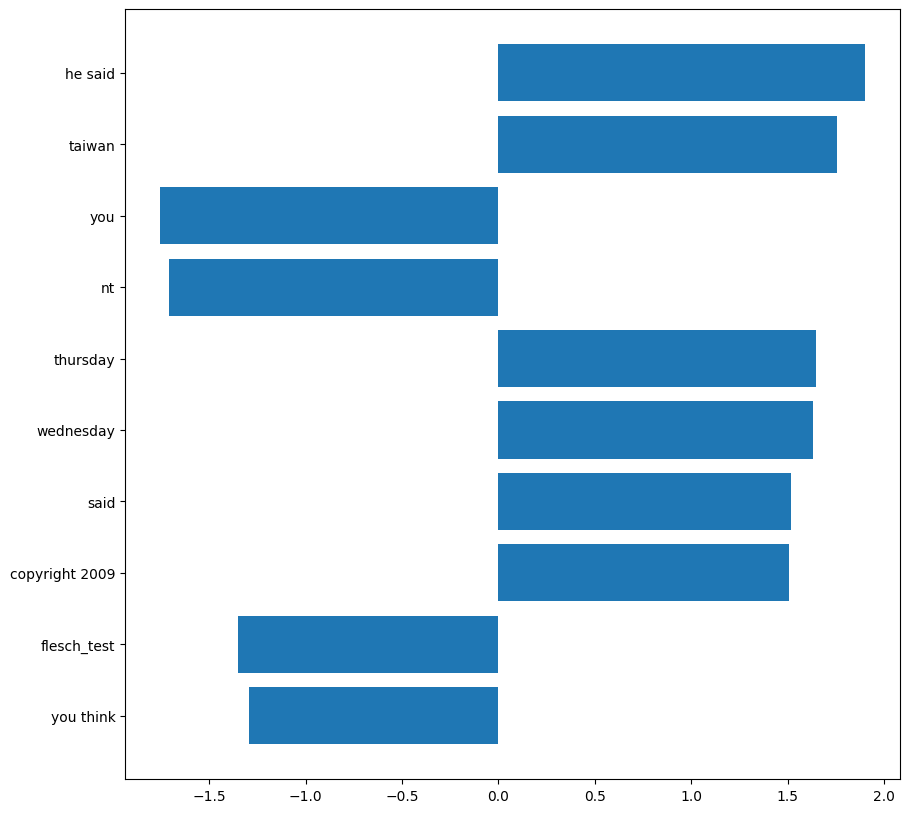

In [33]:
# Get all column names for features
feature_names = np.empty(0)
feature_names = np.concatenate((feature_names, tfidf_vectorizer.get_feature_names_out(), \
                                tf_vectorizer.get_feature_names_out(), \
                                np.array([f"summation_vector_{i}" for i in range(X_test_word2vec.shape[1])]), \
                                np.array(["count_pp"]), \
                                np.array(["count_words"]), \
                                np.array(["count_uppercase"]), \
                                np.array(["flesch_test"]), \
                                np.array([f"verb_count_{verb}" for verb in ['VBZ', 'VBP', 'VBN', 'VBG', 'VBD', 'VB']])
                                ))
feature_names = feature_names[feature_selector.get_support()]

# Get coefficients for Logistic Regression
labels_coefficients = model.coef_
NUM_HIGHEST_ABS_COEFF = 10
row = 1
for label_coefficients in labels_coefficients:
    plt.clf()
    plt.figure(figsize=(10, 10))
    label_coefficients_abs = np.abs(label_coefficients)
    top_indices = np.argsort(label_coefficients_abs)[-NUM_HIGHEST_ABS_COEFF:]
    top_feature_names = feature_names[top_indices]
    top_coeffs = label_coefficients[top_indices]
    plt.barh(top_feature_names, top_coeffs)
    plt.savefig(f"Best-features-coeff-label-{row}.png")
    row += 1


#### Rejection of classification - rejection by probability threshold

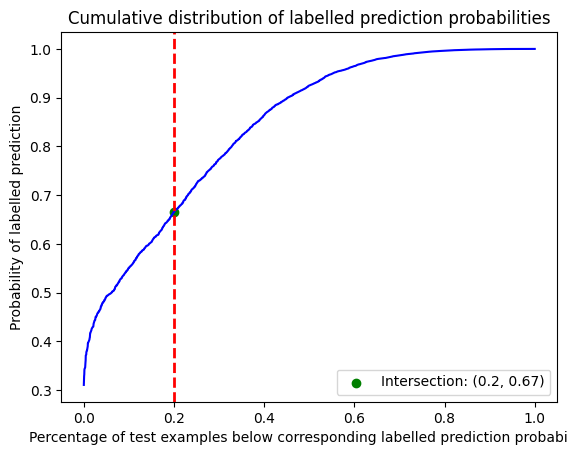

In [34]:
REJECTION_PERCENTAGE = 0.2 # percentage of examples that are rejected 

y_pred_prob = model.predict_proba(X_test_final)
y_pred_prob_max = np.sort(np.max(y_pred_prob, axis=1))
x_range = np.arange(1, len(y_pred_prob_max) + 1) / len(y_pred_prob_max)

rejection_index = int(len(y_pred_prob_max) * REJECTION_PERCENTAGE)
labelled_prediction_rejection_prob = y_pred_prob_max[rejection_index]

plt.plot(x_range, y_pred_prob_max, color='b')
plt.axvline(REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(REJECTION_PERCENTAGE, labelled_prediction_rejection_prob, color='green', label=f'Intersection: ({REJECTION_PERCENTAGE}, {labelled_prediction_rejection_prob:.2f})')
plt.legend()
plt.xlabel('Percentage of test examples below corresponding labelled prediction probability')
plt.ylabel('Probability of labelled prediction')
plt.title('Cumulative distribution of labelled prediction probabilities')
plt.show()

#### Rejection of classification - rejection by distance in document embedding space

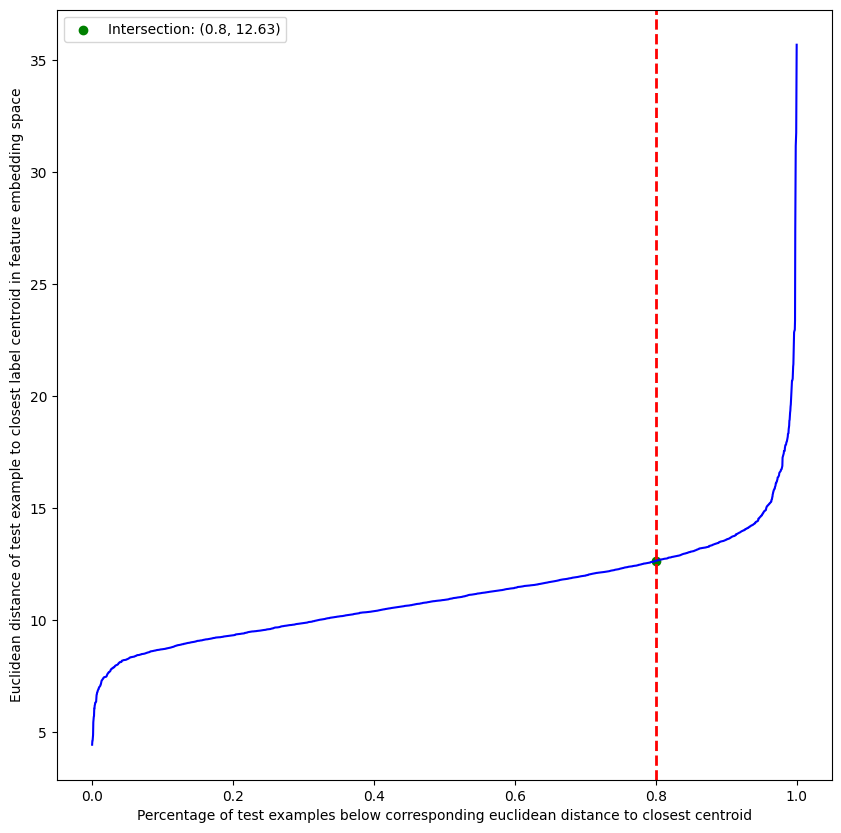

In [35]:
# 1) Filter by y_train
# 2) mean on each column for each labels "centroid"
# 3) Find distance from "centroid" to current
unique_labels = np.unique(y_train)
mean_labels = np.zeros((len(unique_labels), X_train.shape[1]))

row = 0
for label in unique_labels:
    indices = y_train.index[y_train == label]
    points = X_train[indices]
    label_mean_point = points.mean(axis=0)
    mean_labels[row] = label_mean_point
    row += 1

distances = pairwise_distances(X_test_final.toarray(), mean_labels, metric='euclidean')
min_distances = np.min(distances, axis=1)
min_distances = min_distances.flatten()
min_distances.sort()

x_range = np.arange(1, len(min_distances) + 1) / len(min_distances)
rejection_index = int(len(min_distances) * (1 - REJECTION_PERCENTAGE))
euc_dist_rejection_boundary = min_distances[rejection_index]

plt.figure(figsize=(10, 10))
plt.axvline(1 - REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(1 - REJECTION_PERCENTAGE, euc_dist_rejection_boundary, color='green', label=f'Intersection: ({1 - REJECTION_PERCENTAGE}, {euc_dist_rejection_boundary:.2f})')
plt.legend()
plt.plot(x_range, min_distances, color='b')
plt.xlabel('Percentage of test examples below corresponding euclidean distance to closest centroid')
plt.ylabel('Euclidean distance of test example to closest label centroid in feature embedding space')
plt.show()

### Extra code

In [36]:
# # do prediction on training data
# y_train_predicted = model.predict(X_train)

# # obtain training f1 score
# f1_score(y_train, y_train_predicted, average='macro') # TODO this tests the model on its already trained set...

In [37]:
# # obtain predictions on test data
# y_pred = model.predict(X_test)

# # obtain test f1 score
# f1_score(y_test, y_pred, average= 'macro')

In [38]:
### Hyper Parameter tuning with GridSearchCV()

# DEPRECATED FEATURES

In [39]:

# 2) Sentiment analysis
# def sentiment_analysis(sentence):
#     doc = spacy_model(sentence)
#     return doc._.blob.polarity

# X_train_sent_ana = X_train_unprocessed.apply(sentiment_analysis).to_numpy().reshape(-1, 1)

# ## Analysis of sentiment feature
# count_analysis(X_train_sent_ana, y_train)

# # Save sentiment analysis output
# pd_sent_ana = pd.DataFrame(X_train_sent_ana, columns=["Sentiment"])
# compression_opts = dict(method='zip', archive_name='sent_ana.csv')
# pd_sent_ana.to_csv('features/sent_ana.zip', index=False, compression=compression_opts)

# 3) Subjectivity analysis 
# def subjectivity_analysis(sentence):
#     doc = spacy_model(sentence)
#     return doc._.blob.subjectivity

# X_train_subj_ana = X_train_unprocessed.apply(subjectivity_analysis).to_numpy().reshape(-1, 1)

# ## Analysis of subjectivity feature
# count_analysis(X_train_subj_ana, y_train)

# # Save sentiment analysis output
# pd_subj_ana = pd.DataFrame(X_train_subj_ana, columns=["Subjectivity"])
# compression_opts = dict(method='zip', archive_name='subj_ana.csv')
# pd_subj_ana.to_csv('features/subj_ana.zip', index=False, compression=compression_opts)

# 4) Number of exclamation and question marks (pre-analyze first)
# def count_exclamation_marks(sentence):
#     return len(re.findall(r'\!', sentence))

# def count_question_marks(sentence):
#     return len(re.findall(r'\?', sentence))

# X_train_count_ex = X_train.apply(count_exclamation_marks).to_numpy().reshape(-1, 1)
# X_train_count_qn = X_train.apply(count_question_marks).to_numpy().reshape(-1, 1)

# count_analysis(X_train_count_ex, y_train, "Exclamation mark")
# count_analysis(X_train_count_qn, y_train, "Question mark")

# 5) Count number of sentences
# def count_sentences(sentences):
#     return len(nltk.sent_tokenize(sentences)) 

# X_train_count_sentences = X_train.apply(count_sentences).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_count_sentences, y_train, "sentence_count")

# 7) text2emotion (takes too around 6 hours)
# def emotion_vector(sentences):
#     res = np.zeros((len(sentences), 5)) # Angry, Fear, Happy, Sad, Surprise
#     row = 0
#     for sentence in sentences:
#         d = te.get_emotion(sentence)
#         emotion_sorted = sorted(d.items(), key=lambda tup: tup[0])
#         values = np.fromiter(map(lambda tup: tup[1], emotion_sorted), dtype=float)
#         res[row] = values
#         row += 1
#     return res

# X_train_emotion = emotion_vector(X_train_unprocessed).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_emotion[:, 0], y_train, "emotion_angry")
# count_analysis_scatter(X_train_emotion[:, 1], y_train, "emotion_fear")
# count_analysis_scatter(X_train_emotion[:, 2], y_train, "emotion_happy")
# count_analysis_scatter(X_train_emotion[:, 3], y_train, "emotion_sad")
# count_analysis_scatter(X_train_emotion[:, 4], y_train, "emotion_surprise")


In [40]:
#### Rejection of classification - rejection by distance in document embedding space

# DEPRECATED DO NOT USE

# pca_model = TruncatedSVD(n_components=2, random_state=SEED) # 2 dimension for plotting and visualization
# X_train_pca_features = pca_model.fit_transform(X_train, y_train)

# for i in range(1, 5):
#     indices = y_train.index[y_train == i]
#     points = X_train_pca_features[indices]
#     plt.scatter(points[:, 0], points[:, 1], label=i)
# plt.legend()
# plt.show()